<a href="https://colab.research.google.com/github/PyBlin/Study/blob/main/PyML/Chapter4_Classification/Chap4_6_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.XGBoost( eXtra Gradient Boost )

## 6.1 XGBoost Intro

* Kaggle 상위의 많은 데이터 과학자들이 이용하면서 널리 알려졌습니다.
* 다른 ML 알고리즘보다 뛰어난 예측 성능을 나타냅니다.
* GBM 기반이지만, 느린 수행시간과 과적합 규제( Regularization )의 부재 등의 문제를 해결해서 매우 각광을 받고 있습니다.
* 특히 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠릅니다.
* 주요 장점은 다음과 같습니다.
>* 뛰어난 예측 성능
>* GBM 대비 빠른 수행 시간
>* Regularization
>* Tree Pruning( 가지치기 )
>* 자체 내장된 Cross Validation
>* 결손값 자체 처리

* Python Wrapper Module
>* 초기에는 사이킷런과 호환되지 않았습니다.

* Scikit-Learn Wrapper Module
>* 사이킷런과 호환이 가능해졌습니다.

## 6.2 XGBoost Install

* Window : conda install -c anaconda py-xgboost
* Linux : conda install -c conda-forge xgboost

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

print(xgb.__version__)

0.90


## 6.3 Python Wrapper XGBoost - Hyper Parameter

### 6.3.1 주요 일반 파라미터

* `booster=gbtree`
>* `gbtree` : tree based model
>* `gblinear` : linear model

* `silent=0`
>* 출력 메세지를 나타내고 싶지 않을 경우 1로 설정합니다.

* `nthread`
>* CPU 실행 스레드 개수를 조정합니다.
>* default : 전체 스레드 사용
>* 멀티 코어/스레드 CPU 시스템에서 일부 CPU만 사용해 ML 애플리케이션을 구동할 경우에 변경합니다.

### 6.3.2 주요 부스터 파라미터

* `eta=3` [ alias : learning_rate ]
* `num_boost_rounds`
* `min_child_weight=1`
* `gamma=0` [ alias : min_split_loss ]
* `max_depth=6`
* `sub_sample=1`
* `colsample_bytree=1`
* `lambda=1` [ alias : reg_lambda ]
* `alpha=0` [ alias : reg_alpha ]
* `scale_pos_weight=1`

### 6.3.3 학습 태스크 파라미터

* `objective`
>* 최솟값을 가져야할 손실 함수를 정의합니다.
>* XGBoost는 많은 유형의 손실함수를 사용할 수 있습니다.
>* 주로 사용되는 손실함수는 이진 분류인지 다중 분류인지에 따라 달라집니다.

* `binary:logistic`
>* 이진 분류일 때 적용합니다.

* `multi:softmax`
>* 다중 분류일 때 적용합니다.
>* 손실함수가 `multi:softmax`일 경우 레이블 클래스의 개수인 `num_class` 파라미터를 지정해야 합니다.

* `multi:softprob`
>* `multi:softmax`와 유사하나 개별 레이블 클래스의 해당되는 예측 확률을 반환합니다.

* `eval_metric`
>* 검증에 사용되는 함수를 정의합니다.
>* 기본값은 회귀인 경우 `rmse`, 분류일 경우 `error`입니다.
>* 다음은 `eval_metric`의 값 유형입니다.
>>* `rmse` : Root Mean Square Error
>>* `mae` : Mean Absolute Error
>>* `logloss` : Negative Log-Likelihood
>>* `error` : Binary Classification Error Rate ( 0.5 threshold )
>>* `merror` : Multiclass Classification Error Rate
>>* `mlogloss` : Multiclass Logloss
>>* `auc` : Area Under the Curve

### 6.3.4 과적합과 조기 중단( Early Stopping )

* 과적합 문제가 심각하다면 다음과 같이 적용할 것을 고려합니다.
>* `eta` 값을 낮춥니다. ( 0.01 ~ 0.1 )
>>* `eta` 값을 낮출 경우 `num_round`(or `n_estimator`)는 반대로 높여줍니다.
>* `max_depth` 값을 낮춥니다.
>* `min_child_weight` 값을 높입니다.
>* `gamma` 값을 높입니다.
>* `subsample`, `colsample_bytree`를 조정해 트리의 복잡함을 막아줍니다.

* 조기 중단( Early Stopping )
>* 기본 GBM의 경우 `n_estimator`(or `num_boost_rounds`)에 지정된 횟수만큼 반복적으로 학습 오류를 감소시키며 학습을 진행하므로 중간에 반복을 멈출 수 없습니다.
>* XGBoost, LightGBM 모두 조기 중단 기능이 있어 `n_estimator`에 지정한 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 더 이상 개선되지 않으면 중지할 수 있습니다.
>* 예를 들어 `n_estimator=200`에 조기 중단 파라미터를 50으로 설정하면, 부스팅을 200까지 반복하다가 중간에 반복되는 50회 동안 학습 오류가 감소하지 않으면 종료합니다.
>>* 100회 학습 오류 값 = 0.8
>>* 101 ~ 150회 예측 오류 값 >= 0.8
>>* 부스팅 종료

## 6.4 Python Wrapper XGBoost - 위스콘신 유방암 예측

* 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성( malignant )인지 양성( benign )인지 분류한 데이터셋입니다.
* 양성 종양이 비교적 성장 속도가 느리고 전이되지 않습니다.
* 악성 종양은 주위 조직에 침입하면서 빠르게 성장하고 신체 각 부위에 확산되거나 전이되어 생명을 위협합니다.

In [2]:
# plot_importance : 피처의 중요도를 시각화해주는 모듈
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


* 타깃 레이블값의 종류는 악성은 '0'으로, 양성은 '1'로 되어 있습니다.

In [3]:
print(dataset.target_names)
cancer_df['target'].value_counts()

['malignant' 'benign']


1    357
0    212
Name: target, dtype: int64

* 양성이 357개, 악성이 212개입니다.

In [4]:
# 전체 데이터 중 80% 학습용, 20% 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, 
                                                    test_size=0.2, 
                                                    random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


* 파이썬 래퍼 XGBoost는 학습용과 테스트용 데이터셋을 위해 DMatrix를 생성합니다.
* 주로 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost 전용 데이터셋입니다.
* DMatrix 주요 입력 파라미터는 `data`와 `label`입니다.
>* `data` : 피처 데이터셋
>* `label` : 분류일 경우 레이블 데이터셋, 회귀일 경우 숫자형 종속값 데이터셋

In [5]:
# DMatrix
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

* 위 코드는 넘파이 형태의 학습/테스트 데이터셋을 DMatrix로 변환합니다.

In [6]:
params = {'max_depth':3, 'eta':0.1, 'objective':'binary:logistic', 
          'eval_metric':'logloss', 'early_stoppings':100}
num_rounds = 400

* XGBoost Hyper Parameters
>* `max_depth` : 트리 최대 깊이
>* `eta` : 학습률
>>* XGBClassifier일 경우 `eta`가 아니라 `learning_rate`
>* `objective` : 목적함수
>* `eval_metric` : 오류 함수의 평가 성능 지표
>* `early_stopping` : 조기 중단
>* `num_rounds` : 부스팅 반복 횟수

* 이제 XGBoost 모델을 학습시켜 봅시다!
* xgboost의 `train()` 함수에 `early_stopping_rounds` 파라미터를 설정해 조기 중단을 수행할 수 있습니다.
* 이를 위해서는 반드시 `eval_set`과 `eval_metric`을 함께 설정해야 합니다.
>* `eval_set` : 성능 평가를 수행할 평가용 데이터셋을 설정합니다.
>* `eval_metric` : 평가셋에 적용할 성능 평가 방법. 분류일 경우 주로 'error'나 'logloss'를 적용합니다.

In [7]:
# train 데이터셋은 'train', evaluation(test) 데이터셋은 'eval'
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, 
                      early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

* 반복 시 train-logloss( error )와 eval-logloss가 지속적으로 감소합니다.
* 이제 테스트 데이터셋에 예측을 수행해 봅시다!
* 사이킷런의 `predict()` 메서드는 예측 결과 클래스값(0, 1)을 반환합니다.
* xgboost의 `predict()` 함수는 예측 결과를 추정할 수 있는 확률 값을 반환합니다.
* 본 예제는 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 하겠습니다.

In [8]:
pred_probs = xgb_model.predict(dtest)
print("결과값 10개만 표시, 예측 확률값으로 표시됨")
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0 --> preds 리스트에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print(f"예측값 10개만 표시 : {preds[:10]}")

결과값 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시 : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


* 3장에서 생성한 get_clf_eval() 함수를 적용해 XGBoost 모델의 예측 성능을 평가해 봅시다!

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
roc_auc_score, f1_score, confusion_matrix

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print(f"Confusion Matrix : \n{confusion}")
    print(f"\nAccuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"ROC AUC   : {roc_auc:.4f}")

In [10]:
get_clf_eval(y_test, preds, pred_probs)

Confusion Matrix : 
[[35  2]
 [ 1 76]]

Accuracy  : 0.9737
Precision : 0.9744
Recall    : 0.9870
F1 Score  : 0.9806
ROC AUC   : 0.9951


* 이번엔 xgboost 패키지에 내장된 시각화 기능을 수행해 봅시다!
* xgboost의 `plot_importance()` API는 기본 평가 지표로 f1 스코어를 기반으로 합니다.
* 넘파이 기반의 피처 데이터로 학습 시 피처명을 제대로 알 수 없으므로 f0, f1 같이 순서별로 f자 뒤에 순서를 붙여서 X축에 피처들로 나열합니다.
>* f0 : 첫 번째 피처
>* f1 : 두 번째 피처
>* ...

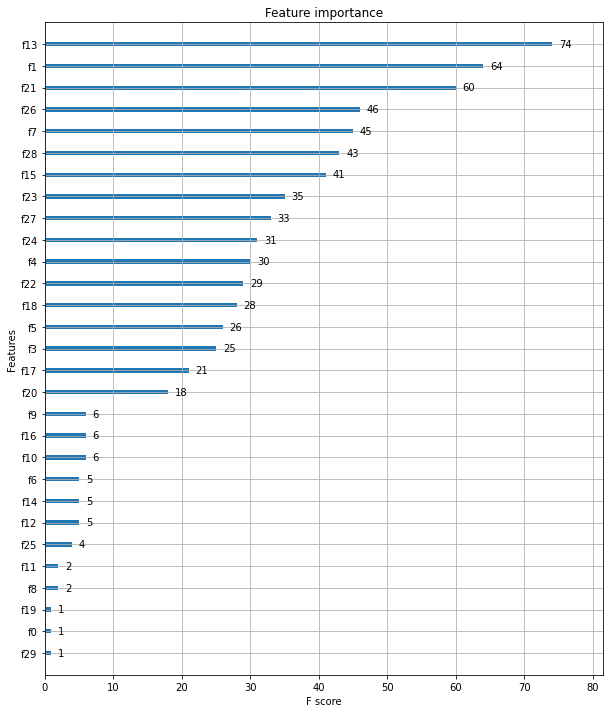

In [11]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax);